In [1]:
import time
import matplotlib.pyplot as plt, matplotlib.animation
import numpy as np

In [2]:
#PHYSICS
Viscosity = 0.01           # вязкость жидкости
Height, Width = 80, 200    # размеры решетки

U0 = np.array([0.10, 0])    # начальная скорость

Ux  = np.zeros((Height, Width)) + U0[0]
Uy  = np.zeros((Height, Width)) + U0[1]
Rho = np.ones((Height, Width))

Ux0  = Ux.copy()
Uy0  = Uy.copy()
Rho0 = Rho.copy()

In [3]:
def BarrierShape(x0, y0, r):
    """ Инициализируем форму барьера. Необходимо установить True там, где барьер """
    barrier = np.zeros((Height, Width), bool)

    # круг
    for y in range(barrier.shape[0]):
        for x in range(barrier.shape[1]):
            if (x - x0)**2 + (y - y0)**2 < r**2:
                barrier[y,x] = True
    return barrier

In [4]:
shift_x = 1
shift_y = 1

In [5]:
def next_b(x, y, r):
    global shift_x, shift_y

    if (x - r + shift_x < 0 or x + r + shift_x > Width):
        shift_x = -1 * shift_x
    if (y - r + shift_y < 0 or y + r + shift_y > Height):
        shift_y = -1 * shift_y
        
    x = x + shift_x
    y = y + shift_y

    return x, y

In [6]:
## D2Q9
D = 2
Q = 9

V = np.array([
    [-1, 1],[ 0, 1],[ 1, 1],
    [-1, 0],[ 0, 0],[ 1, 0],
    [-1,-1],[ 0,-1],[ 1,-1]
])

W = np.array([
    1/36, 1/9, 1/36,
    1/9,  4/9, 1/9,
    1/36, 1/9, 1/36
])

C = 1/3**0.5

In [7]:
def setBarrier(x, y ,r):
    barrierC = BarrierShape(x, y, r)

    barrierN = np.roll(barrierC,  1, axis=0)
    barrierS = np.roll(barrierC, -1, axis=0)
    barrierE = np.roll(barrierC,  1, axis=1)
    barrierW = np.roll(barrierC, -1, axis=1)
    barrierNE = np.roll(barrierN,  1, axis=1)
    barrierNW = np.roll(barrierN, -1, axis=1)
    barrierSE = np.roll(barrierS,  1, axis=1)
    barrierSW = np.roll(barrierS, -1, axis=1)

    return np.array([barrierNW, barrierN, barrierNE,
                     barrierW,  barrierC, barrierE,
                     barrierSW, barrierS, barrierSE])


In [8]:
def F_stat(Ux, Uy, Rho):
    UV = np.zeros((Q, Height, Width))
    for q in range(Q):
        UV[q] = (V[q,0]*Ux + V[q,1]*Uy)/C**2

    U2 = (Ux**2 + Uy**2)/C**2

    f_stat = np.zeros((Q, Height, Width))
    for q in range(Q):
        f_stat[q] = Rho * W[q] * (1 + UV[q] + 0.5*(UV[q]**2) - 0.5*U2)
    return f_stat

def Mode0(f):
    mode = np.zeros((Height, Width))
    for q in range(Q):
        mode += f[q]
    return mode

def Mode1(f):
    mode = np.zeros((D, Height, Width))
    for q in range(Q):
        for d1 in range(D):
            mode[d1] += f[q]*V[q,d1]
    return mode

In [9]:
def curl(ux, uy):
    return np.roll(uy,-1,axis=1) - np.roll(uy,1,axis=1) - np.roll(ux,-1,axis=0) + np.roll(ux,1,axis=0)

In [10]:
def iter(f, f_out, barrier):
    #now = time.time()
   
   
    (fNW, fN, fNE, fW, fC, fE, fSW, fS, fSE) = f

    # Stream step
    for y in range(Height-1,0,-1):
        fN[y]  = fN[y-1]
        fNE[y] = fNE[y-1]
        fNW[y] = fNW[y-1]

    fS[:-1]  = fS[1:]
    fSE[:-1] = fSE[1:]
    fSW[:-1] = fSW[1:]

    fE[:,1:]  = fE[:,:-1]
    fNE[:,1:] = fNE[:,:-1]
    fSE[:,1:] = fSE[:,:-1]

    fW[:,:-1]  = fW[:,1:]
    fNW[:,:-1] = fNW[:,1:]
    fSW[:,:-1] = fSW[:,1:]

    # BC_barrier
    (bNW, bN, bNE, bW, bC, bE, bSW, bS, bSE) = barrier
    fN[bN]   = fS[bC]
    fS[bS]   = fN[bC]
    fE[bE]   = fW[bC]
    fW[bW]   = fE[bC]
    fNE[bNE] = fSW[bC]
    fNW[bNW] = fSE[bC]
    fSE[bSE] = fNW[bC]
    fSW[bSW] = fNE[bC]

    # Compute macroscopic variables
    Rho = Mode0(f)
    UxUy = Mode1(f)
    Ux = UxUy[0]/Rho
    Uy = UxUy[1]/Rho

    # Collision step with updated equilibrium
    f_eq = F_stat(Ux, Uy, Rho)
    tau = 0.5 + Viscosity/C**2
    f += (f_eq - f)/tau

    # BC_out (if needed)
    f[:,0,:] = f_out[:,0,:]
    f[:,-1,:] = f_out[:,-1,:]
    f[:,:,0] = f_out[:,:,0]
    f[:,:,-1] = f_out[:,:,-1]

    #print(time.time()-now)

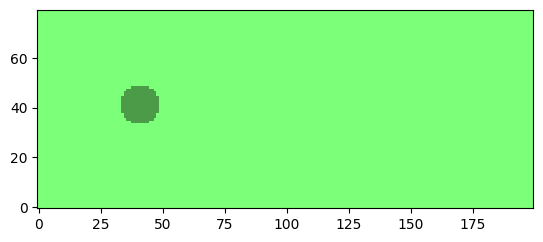

In [11]:
#barrier = InitBarrier()
F = F_stat(Ux, Uy, Rho)
F_out = F_stat(Ux, Uy, Rho)

center_x = Height//2
center_y = Height//2
r = Height//10

# Initial iterations
center_x, center_y = next_b(center_x, center_y, r)
barrier = setBarrier(center_x, center_y, r)

for _ in range(40):
    iter(F, F_out, barrier)

fig, ax = plt.subplots()
fluidImage = ax.imshow(curl(Ux, Uy), origin='lower', 
                       norm=plt.Normalize(-.1,.1), 
                       cmap=plt.get_cmap('jet'),
                       interpolation='none')


bImageArray = np.zeros((Height, Width, 4), np.uint8)
bImageArray[barrier[4],3] = 100
barrierImage = plt.imshow(bImageArray, origin='lower', interpolation='none')

def nextFrame(_):
    global center_x,center_y
    
    center_x, center_y = next_b(center_x, center_y, r)
    barrier = setBarrier(center_x, center_y, r)
    for _ in range(40):    
        iter(F, F_out, barrier)

    
    Rho = Mode0(F)
    UxUy = Mode1(F)
    Ux = UxUy[0]/Rho
    Uy = UxUy[1]/Rho
    tmp_bImageArray = np.zeros((Height, Width, 4), np.uint8)
    tmp_bImageArray[barrier[4],3] = 100
    fluidImage.set_array(curl(Ux, Uy))
    barrierImage.set_array(tmp_bImageArray)
    return (fluidImage, barrierImage)

In [12]:
animate = matplotlib.animation.FuncAnimation(fig, nextFrame, frames=500, interval=1, blit=True)

In [13]:
animate.save("like_dvd.mp4", fps = 15)
plt.show()